# Setup

In [1]:
import argparse
import os
import pathlib
from inpaint_config import InPaintConfig
from datetime import datetime
import shutil
import re
import requests
import argparse
from skimage import io
import os
import pathlib
import numpy as np
from inpaint_config import InPaintConfig
from inpaint_tools import read_file_list

import torchvision.transforms as transforms
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

settings = {
	"team_data": {
		"name": "FelineFixer"
	},
	"training_parms": {
		"method": "Autoencoder",
		"dummy_value": 1000
	},
	"dirs": {
		"input_data_dir": "C:/Users/wkg579/Documents/3_courses/summerschool_missing_data_augmentation/MissingDataOpenData",
		"output_data_dir": "C:/Users/wkg579/Documents/3_courses/summerschool_missing_data_augmentation/MissingDataOpenDataOutput"
	},
	# "challenge_server": {
	# 	"address": "http://fungi.compute.dtu.dk:8080"
	# }
}

In [2]:
cwd = pathlib.Path.cwd()
FPATH_PICTURES = cwd / "pictures"

In [3]:
name_model = "trained_model"
name_training_data = "training"
subsample_amount = 250
settings['data_set'] = name_training_data

# Load data

In [4]:
def load_scale_channel_first(img):
    """Turn RGB into floats and reorder to channel first
    H x W x C -> C X H X W"""
    tensor = torch.from_numpy(img)
    tensor_float = tensor/255.0
    tensor_channel_first = tensor_float.permute(2, 0, 1)
    return tensor_channel_first

In [5]:
input_data_dir = settings["dirs"]["input_data_dir"]
output_data_dir = settings["dirs"]["output_data_dir"]
training_set = settings["data_set"] + ".txt"
output_dir = os.path.join(output_data_dir, name_model)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

print(f'Training inpainter with data set: {training_set} and placing model in {output_dir}')

file_list = os.path.join(input_data_dir, "data_splits", training_set)
file_ids = read_file_list(file_list)[:subsample_amount]
# if file_ids is None:
#     return

print(f"Training on {len(file_ids)} images")

tensor_unmasked_list = []
tensor_masked_list = []

for idx in file_ids:
    org_fname = os.path.join(input_data_dir, "originals", f"{idx}.jpg")
    org_im = io.imread(org_fname)

    mask_fname = os.path.join(input_data_dir, "masked", f"{idx}_stroke_masked.png")
    mask_im = io.imread(mask_fname)
    
    tensor_unmasked_list.append(load_scale_channel_first(org_im))
    tensor_masked_list.append(load_scale_channel_first(mask_im))

Training inpainter with data set: training.txt and placing model in C:/Users/wkg579/Documents/3_courses/summerschool_missing_data_augmentation/MissingDataOpenDataOutput\trained_model
Training on 250 images


# Define model

In [6]:
# Define a simple autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Train

In [7]:
NUM_EPOCHS = 10
BATCH_SIZE = 1

# Load your dataset
train_dataset = TensorDataset(torch.stack(tensor_masked_list), torch.stack(tensor_unmasked_list))

# Create train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the autoencoder, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    # Create a progress bar using tqdm
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Update progress bar description with loss
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=loss.item())

            # Accumulate loss for this epoch
            running_loss += loss.item()

    # Calculate and print average loss for the epoch
    average_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Loss: {average_loss:.4f}")

Epoch 1: 100%|██████████| 250/250 [00:21<00:00, 11.41batch/s, loss=0.0385] 


Epoch [1/10], Average Loss: 0.0575


Epoch 2: 100%|██████████| 250/250 [00:23<00:00, 10.71batch/s, loss=0.0118] 


Epoch [2/10], Average Loss: 0.0325


Epoch 3: 100%|██████████| 250/250 [00:22<00:00, 11.19batch/s, loss=0.0155] 


Epoch [3/10], Average Loss: 0.0306


Epoch 4: 100%|██████████| 250/250 [00:22<00:00, 11.24batch/s, loss=0.0232] 


Epoch [4/10], Average Loss: 0.0298


Epoch 5: 100%|██████████| 250/250 [00:22<00:00, 10.93batch/s, loss=0.0237] 


Epoch [5/10], Average Loss: 0.0292


Epoch 6: 100%|██████████| 250/250 [00:22<00:00, 11.18batch/s, loss=0.014]  


Epoch [6/10], Average Loss: 0.0287


Epoch 7: 100%|██████████| 250/250 [00:22<00:00, 11.11batch/s, loss=0.0379] 


Epoch [7/10], Average Loss: 0.0284


Epoch 8: 100%|██████████| 250/250 [00:23<00:00, 10.67batch/s, loss=0.0436] 


Epoch [8/10], Average Loss: 0.0282


Epoch 9: 100%|██████████| 250/250 [00:22<00:00, 11.09batch/s, loss=0.011]  


Epoch [9/10], Average Loss: 0.0279


Epoch 10: 100%|██████████| 250/250 [00:21<00:00, 11.39batch/s, loss=0.0262] 

Epoch [10/10], Average Loss: 0.0279


# Inference

In [8]:
# Set the model to evaluation mode
model.eval()

# Define a transformation to convert tensor to PIL image
to_pil = transforms.ToPILImage()

# Perform inference and save images
for batch_idx, (inputs, _) in enumerate(train_loader):

    # Perform forward pass through the model
    with torch.no_grad():
        outputs = model(inputs)

    # Convert the output tensor to a PIL image
    output_image = to_pil(outputs[0].cpu())  # Assuming batch size 1

    # Save the output image
    output_image.save(FPATH_PICTURES / f'output_image_{batch_idx}.png')

In [9]:
batch = next(iter(train_loader))

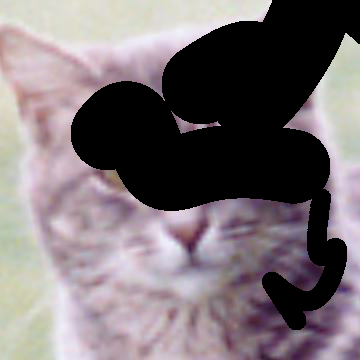

In [10]:
to_pil(batch[0][0])

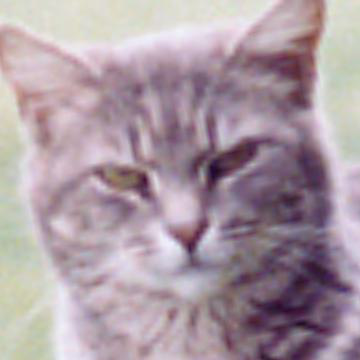

In [11]:
to_pil(batch[1][0])

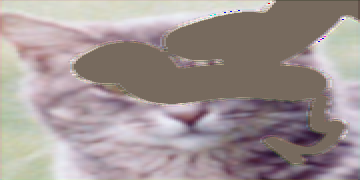

In [12]:
to_pil(model(batch[0][0]))

# Generation

In [13]:
latent_dim = [16, 180, 180]  # Replace with the actual latent dimension of your model
num_samples = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_vectors = torch.randn(num_samples, *latent_dim).to(device)

# Pass latent vectors through the decoder
with torch.no_grad():
    generated_images = model.decoder(latent_vectors)

# Convert the output tensors to images
to_pil = transforms.ToPILImage()
generated_images = generated_images.cpu()  # Move tensors to CPU
generated_images = torch.clamp(generated_images, min=0.0, max=1.0)  # Clamp values to [0, 1]

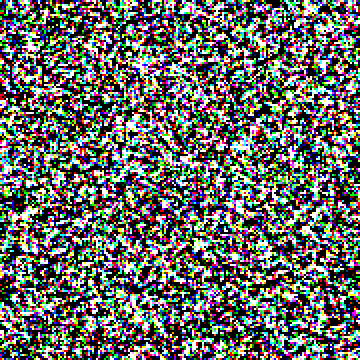

In [14]:
generated_image = to_pil(generated_images[0])
# Perfect!
generated_image